In [1]:
import numpy as np
import pandas as pd
import re
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset, random_split
from torch.optim.lr_scheduler import CosineAnnealingLR
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf, ccf
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from typing import List, Tuple
import logging
from gensim.models import Word2Vec
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_score
import seaborn as sns
import torch.nn.functional as F

In [2]:
def similarity_cosine(vec1, vec2):
    cosine_similarity_arr = []
    for v1,v2 in zip(vec1, vec2):
        cosine_similarity = np.dot(v1, v2)/(np.linalg.norm(v1)* np.linalg.norm(v2))
        cosine_similarity_arr.append(cosine_similarity)
    return np.array(cosine_similarity_arr)

def keep_words_with_underscore(input_string):
    # Define a regular expression pattern to match words with underscores
    pattern = r'\b\w*_[\w_]*\b'

    # Use re.findall to extract words that match the pattern
    matching_words = re.findall(pattern, input_string)

    # Join the matching words to form the final string
    result = ' '.join(matching_words)
    return result

def update_co_occurrences(word_year_list,word_co_occurrences):
    # Iterate through the words in the list
    word_list, year = word_year_list
    
    for word in word_list:
        # If the word is not already in the dictionary, add it with an empty list
        if word not in word_co_occurrences:
            word_co_occurrences[word] = {}
        
        # Add words from the list to the co-occurrence list for the current word
        for other_word in word_list:
            # if other_word != word and other_word not in word_co_occurrences[word]:
            #     word_co_occurrences[word].append(other_word)
            if other_word != word and other_word not in word_co_occurrences[word]:
                word_co_occurrences[word][other_word] = [year] 
            
            elif other_word != word and other_word in word_co_occurrences[word]:
                # word_co_occurrences[word][other_word][0] +=1
                word_co_occurrences[word][other_word].append(year)

### Get Word Co-Occurances

In [3]:
concept_filtered_arr = np.load("saved_files/overlapping_filtered_5_concepts.npy")
ngram_abstracts = np.load("saved_files/ngram_abstracts.npy", mmap_mode="r")
saved_year_arr = np.load("saved_files/year_arr.npy", mmap_mode="r")

print("Concepts which were tracked",concept_filtered_arr.shape)
print("Abstracts",ngram_abstracts.shape)
print("Year associated to abstract",saved_year_arr.shape)

phys_filtered_concept_dict = {k:1 for k in concept_filtered_arr}
ocurr_arr = []
for abstract, year in zip(ngram_abstracts, saved_year_arr):
    temp = keep_words_with_underscore(abstract)
    if temp.count(" ") > 0:
        temp = temp.split(" ") 
        temp = [s for s in temp if s in phys_filtered_concept_dict]
        ocurr_arr.append([list(filter(("_").__ne__, temp)),year])
                        
word_co_occurrences = {}

for word_list in tqdm(ocurr_arr):
    update_co_occurrences(word_list,word_co_occurrences)

Concepts which were tracked (19161,)
Abstracts (157821,)
Year associated to abstract (157821,)


100%|██████████| 152310/152310 [00:06<00:00, 22774.22it/s]


### Get Embedding

In [4]:
def load_model_for_year(year):
    return Word2Vec.load(f"saved_models/model_year_{year}.model")

load = True 
if load:
    c_inx_arr = np.memmap("saved_files/embedding_concept_arr.dat",shape=(19161,), dtype="<U58")
    c_encoding_arr = np.memmap("saved_files/embedding_vector_arr.dat",shape=(19161, 31, 128), dtype=np.float64)

else:
    # Initialize dictionaries and counters
    c_dict = {}
    cnt_0, cnt_1 = 0, 0

    # Get the unique years
    unique_years = np.unique(saved_year_arr)

    # Iterate over each year and load the corresponding model
    for year in tqdm(unique_years):
        loaded_w2v = load_model_for_year(year)

        # Iterate over each concept in the filtered concept dictionary
        for c in phys_filtered_concept_dict:
            if c not in c_dict:
                c_dict[c] = {}

            # If the concept is already recorded for the current year, skip it
            if year in c_dict[c]:
                continue

            try:
                # Get the vector encoding for the concept
                vec_enc = loaded_w2v.wv.get_vector(c)
                c_dict[c][year] = vec_enc
                cnt_0 += 1
            except KeyError:  # Catch specific exception for missing key
                cnt_1 += 1
                pass

    print(f"Found {cnt_0} vectors, missed {cnt_1} vectors.")

    # Initialize lists for lengths and concept indices
    len_arr, len_new_arr, concept_inx_arr = [], [], []

    # Iterate over each concept to fill missing years with the first available vector
    for c in tqdm(phys_filtered_concept_dict):
        l = len(c_dict[c])
        len_arr.append(l)

        if l > 0:
            concept_inx_arr.append(c)
            success_years = sorted(c_dict[c].keys())
            first_success_year = success_years[0]

            # Backtrack and fill in the missing years with the first available vector
            for year in unique_years:
                if year < first_success_year:
                    if year not in c_dict[c]:
                        c_dict[c][year] = c_dict[c][first_success_year]
                else:
                    break

        len_new_arr.append(len(c_dict[c]))

    concept_inx_arr = np.array(concept_inx_arr)

    # Display the distribution of the number of years filled for each concept
    print(np.unique(len_new_arr, return_counts=True))

    # Prepare the encoding array
    num_concepts = len(c_dict)
    num_years = len(unique_years)
    embedding_dim = 128

    c_encoding_arr = np.zeros((num_concepts, num_years, embedding_dim))
    c_inx_arr = []

    # Fill the encoding array with vectors for each concept and year
    for cnt, (concept, year_vectors) in enumerate(c_dict.items()):
        c_encoding_arr[cnt] = np.array([year_vectors.get(year, np.zeros(embedding_dim)) for year in unique_years])
        c_inx_arr.append(concept)

    c_inx_arr = np.array(c_inx_arr)

    
    filename = 'saved_files/embedding_concept_arr.dat'
    memmap_array = np.memmap(filename, dtype=c_inx_arr.dtype, mode='w+', shape=c_inx_arr.shape)
    memmap_array[:] = c_inx_arr
    memmap_array.flush()

    filename = 'saved_files/embedding_vector_arr.dat'
    memmap_array = np.memmap(filename, dtype=c_encoding_arr.dtype, mode='w+', shape=c_encoding_arr.shape)
    memmap_array[:] = c_encoding_arr
    memmap_array.flush()



### Create Dataset

In [5]:
def get_co_occur_concept_pair_after_year_arr(word_co_occurrences: dict, first_occ_year: int, final_occ_year: int) -> np.ndarray:
    co_occur_concept_pair_arr = []
    for concept, v in word_co_occurrences.items():
        for co_concept, years in v.items():
            if np.min(years) >= first_occ_year and np.max(years)<=final_occ_year:
                co_occur_concept_pair_arr.append([concept,co_concept])
    return np.array(co_occur_concept_pair_arr)

def _get_years_range(start: int, end: int) -> np.ndarray:
        return (np.unique(saved_year_arr)[start:] if end == -0 
                                 else np.unique(saved_year_arr)[start:end])

def create_dataset_indexing(data: np.ndarray, word_co_occurrences: dict, year_arr: np.ndarray, c_inx_arr: np.ndarray, 
                 input_window_size: int = 5, output_window_size: int = 3, offset_to_current_year: int = 1, print_test: bool = False, save=True):
    """
    Dataset indexing for time series data.

    Args:
        data (np.ndarray): The input data.
        word_co_occurrences (dict): Dictionary of word co-occurrences.
        year_arr (np.ndarray): Array of years.
        c_inx_arr (np.ndarray): Array of concept indices.
        input_window_size (int, optional): Size of the input window. Defaults to 5.
        output_window_size (int, optional): Size of the output window. Defaults to 3.
        offset_to_current_year (int, optional): Offset to the current year. Defaults to 1.
        print_test (bool, optional): Whether to print test information. Defaults to False.

    Returns:
        np.ndarray: Positive index pair array.
        np.ndarray: Negative index pair array.
    """
    train_window_data = data[:, -input_window_size-output_window_size-offset_to_current_year:-output_window_size-offset_to_current_year]
    label_year_range = (year_arr[-output_window_size:] if offset_to_current_year == 0 
                                else year_arr[-output_window_size-offset_to_current_year:-offset_to_current_year])

    co_occur_concept_pair_arr = get_co_occur_concept_pair_after_year_arr(
        word_co_occurrences, label_year_range[0], label_year_range[-1])


    # Precompute indices for each unique concept in c_inx_arr
    concept_to_indices = {concept: np.where(c_inx_arr == concept)[0] for concept in np.unique(c_inx_arr)}

    # Convert word_co_occurrences to a dictionary of sets for fast membership checking
    word_co_occurrences_set = {k: set(v) for k, v in word_co_occurrences.items()}

    pos_inx_pair_arr = np.zeros((len(co_occur_concept_pair_arr),2), dtype=int)
    
    for inx, pair in enumerate(co_occur_concept_pair_arr):
        pos_inx_pair_arr[inx, 0] = concept_to_indices[pair[0]][0]
        pos_inx_pair_arr[inx, 1] = concept_to_indices[pair[1]][0]

    print("Finished Positives")

    neg_inx_pair_arr = np.zeros((len(co_occur_concept_pair_arr), 2), dtype=int)
    checked_pairs = set()
    neg_inx = 0

    while neg_inx < len(pos_inx_pair_arr):
        sampled_pair = tuple(np.random.choice(train_window_data.shape[0], size=2, replace=False))
        
        # Ensure the sampled pair is not the same and hasn't been checked before
        if sampled_pair not in checked_pairs:
            checked_pairs.add(sampled_pair)
            concept_0, concept_1 = c_inx_arr[sampled_pair[0]], c_inx_arr[sampled_pair[1]]

            if concept_1 not in word_co_occurrences_set.get(concept_0, set()):
                neg_inx_pair_arr[neg_inx, 0] = concept_to_indices[concept_0][0]
                neg_inx_pair_arr[neg_inx, 1] = concept_to_indices[concept_1][0]
                neg_inx += 1
    print("Finished Negatives")

    if print_test:
        save_pos_arr = [word_co_occurrences[c_inx_arr[pos_inx_pair_arr[_][0]]][c_inx_arr[pos_inx_pair_arr[_][1]]] for _ in range(len(pos_inx_pair_arr))]
        save_neg_arr = [c_inx_arr[neg_inx_pair_arr[_][1]] in word_co_occurrences[c_inx_arr[neg_inx_pair_arr[_][0]]] for _ in range(len(neg_inx_pair_arr))]

        save_pos_arr = [x for xs in save_pos_arr for x in xs]
        
        print(f"Training Window: {_get_years_range(-input_window_size-output_window_size-offset_to_current_year, -output_window_size-offset_to_current_year)}")
        print(f"Label Window: {_get_years_range(-output_window_size-offset_to_current_year, -offset_to_current_year)}")

        print("Positive: Expect to be years: ", np.unique(save_pos_arr))
        print("Negative: Expect to be 0: ", np.sum(save_neg_arr))

    if save:
        np.save(f"saved_files/train_pos_inx_pair_arr_{input_window_size}_{output_window_size}_{offset_to_current_year}", pos_inx_pair_arr)
        np.save(f"saved_files/train_neg_inx_pair_arr_{input_window_size}_{output_window_size}_{offset_to_current_year}", neg_inx_pair_arr)

    return pos_inx_pair_arr, neg_inx_pair_arr


seq_length = 5
out_length = 3
batch_size = 128

print("Representation Vectors for tracked concepts",c_encoding_arr.shape)
print("Concept associted with representation", c_inx_arr.shape)
scaler = StandardScaler()
reshaped_data = c_encoding_arr.reshape(-1, c_encoding_arr.shape[-1])  
normalized_data = scaler.fit_transform(reshaped_data)
encoding_data = normalized_data.reshape(c_encoding_arr.shape)

load = True 
if not load:
    train_pos_inx_pair_arr_5_3_3, train_neg_inx_pair_arr_5_3_3 = create_dataset_indexing(data=encoding_data, word_co_occurrences=word_co_occurrences, year_arr = np.unique(saved_year_arr), 
                                c_inx_arr=c_inx_arr, input_window_size = seq_length, output_window_size = out_length, offset_to_current_year = 3, print_test=True)

    train_pos_inx_pair_arr_5_3_0, train_neg_inx_pair_arr_5_3_0 = create_dataset_indexing(data=encoding_data, word_co_occurrences=word_co_occurrences, year_arr = np.unique(saved_year_arr), 
                                c_inx_arr=c_inx_arr, input_window_size = seq_length, output_window_size = out_length, offset_to_current_year = 0, print_test=True)
    
else:
    train_pos_inx_pair_arr_5_3_3 = np.load(f"saved_files/train_pos_inx_pair_arr_{seq_length}_{out_length}_3.npy")
    train_neg_inx_pair_arr_5_3_3 = np.load(f"saved_files/train_neg_inx_pair_arr_{seq_length}_{out_length}_3.npy")

    train_pos_inx_pair_arr_5_3_0 = np.load(f"saved_files/train_pos_inx_pair_arr_{seq_length}_{out_length}_0.npy")
    train_neg_inx_pair_arr_5_3_0 = np.load(f"saved_files/train_neg_inx_pair_arr_{seq_length}_{out_length}_0.npy")


Representation Vectors for tracked concepts (19161, 31, 128)
Concept associted with representation (19161,)


In [6]:
class CustomPairDataset(Dataset):
    def __init__(self, train_window_data, pair_arr, labels, input_window_size, output_window_size, offset_to_current_year):
        self.train_window_data = train_window_data[:, -input_window_size-output_window_size-offset_to_current_year:-output_window_size-offset_to_current_year]
        self.pair_arr = pair_arr
        self.labels = labels
        self.shape = self.train_window_data.shape

    def __len__(self):
        return len(self.pair_arr)

    def __getitem__(self, idx):
        inx_0, inx_1 = self.pair_arr[idx]
        label = self.labels[idx]
        enc_0 = self.train_window_data[inx_0]
        enc_1 = self.train_window_data[inx_1]
        enc_01 = np.concatenate((enc_0, enc_1), axis=-1)
        return torch.from_numpy(enc_01), torch.tensor([label], dtype=torch.float32) 

def create_train_val_datasets(train_window_data, pos_inx_pair_arr, neg_inx_pair_arr, input_window_size, output_window_size, offset_to_current_year, test_size=0.2, random_state=42):
    # Create labels
    pos_labels = np.ones(len(pos_inx_pair_arr))
    neg_labels = np.zeros(len(neg_inx_pair_arr))
    
    # Concatenate positive and negative pairs and labels
    all_pairs = np.vstack((pos_inx_pair_arr, neg_inx_pair_arr))
    all_labels = np.concatenate((pos_labels, neg_labels))
    
    # Split indices into training and test sets
    train_idx, test_idx = train_test_split(
        np.arange(len(all_pairs)), test_size=test_size, random_state=random_state, stratify=all_labels
    )
    
    # Create training and test datasets
    train_dataset = CustomPairDataset(train_window_data, all_pairs[train_idx], all_labels[train_idx], input_window_size, output_window_size, offset_to_current_year)
    test_dataset = CustomPairDataset(train_window_data, all_pairs[test_idx], all_labels[test_idx], input_window_size, output_window_size, offset_to_current_year)
    
    return train_dataset, test_dataset

def create_test_datasets(train_window_data, pos_inx_pair_arr, neg_inx_pair_arr, input_window_size, output_window_size, offset_to_current_year):
    # Create labels
    pos_labels = np.ones(len(pos_inx_pair_arr))
    neg_labels = np.zeros(len(neg_inx_pair_arr))
    
    # Concatenate positive and negative pairs and labels
    all_pairs = np.vstack((pos_inx_pair_arr, neg_inx_pair_arr))
    all_labels = np.concatenate((pos_labels, neg_labels))
     
    return CustomPairDataset(train_window_data, all_pairs, all_labels, input_window_size, output_window_size, offset_to_current_year)

train_dataset, val_dataset = create_train_val_datasets(
    train_window_data=encoding_data, pos_inx_pair_arr=train_pos_inx_pair_arr_5_3_3, neg_inx_pair_arr=train_neg_inx_pair_arr_5_3_3, 
    input_window_size=seq_length, output_window_size=out_length, offset_to_current_year = 3, test_size=0.2)

test_dataset = create_test_datasets(
    train_window_data=encoding_data, pos_inx_pair_arr=train_pos_inx_pair_arr_5_3_0, neg_inx_pair_arr=train_neg_inx_pair_arr_5_3_0, 
    input_window_size=seq_length, output_window_size=out_length, offset_to_current_year = 0)


train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [7]:
class NovelSeriesDataset(Dataset):
    def __init__(self, data: np.ndarray, c_inx_arr: np.ndarray, input_window_size: int = 5):
        """
        Dataset for novel series data.

        Args:
            data (np.ndarray): The input data.
            c_inx_arr (np.ndarray): Array of concept indices.
            input_window_size (int, optional): Size of the input window. Defaults to 5.
        """
        self.train_window_data = data[:, -input_window_size:]
        self.c_inx_arr = c_inx_arr
        self.input_window_size = input_window_size

    def __len__(self) -> int:
        return 64 * 2000

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        while True:
            sampled_pair = np.random.choice(self.train_window_data.shape[0], size=2)
            if self.c_inx_arr[sampled_pair[1]] not in word_co_occurrences[self.c_inx_arr[sampled_pair[0]]]:
                break
        inx_0 = np.where(self.c_inx_arr == self.c_inx_arr[sampled_pair[0]])[0]
        inx_1 = np.where(self.c_inx_arr == self.c_inx_arr[sampled_pair[1]])[0]
        enc_0 = self.train_window_data[inx_0][0]
        enc_1 = self.train_window_data[inx_1][0]
        enc_01 = np.concatenate((enc_0, enc_1), axis=-1)
        return torch.from_numpy(enc_01), torch.from_numpy(np.array([inx_0, inx_1]))

    def _check_indexing(self):
        print(f"Training Window: {np.unique(saved_year_arr)[-self.input_window_size:]}")

novel_dataset = NovelSeriesDataset(data=encoding_data, c_inx_arr=c_inx_arr, input_window_size = seq_length)
novel_dataset._check_indexing()
novel_dataloader = DataLoader(novel_dataset, batch_size=batch_size, shuffle=True)

Training Window: [2020 2021 2022 2023 2024]


In [17]:
class _SepConv1d(nn.Module):
    """A simple separable convolution implementation.
    
    The separable convlution is a method to reduce number of the parameters 
    in the deep learning network for slight decrease in predictions quality.
    """
    def __init__(self, ni, no, kernel, stride, pad):
        super().__init__()
        self.depthwise = nn.Conv1d(ni, ni, kernel, stride, padding=pad, groups=ni)
        self.pointwise = nn.Conv1d(ni, no, kernel_size=1)

    def forward(self, x):
        return self.pointwise(self.depthwise(x))
    
class SepConv1d(nn.Module):
    """Implementes a 1-d convolution with 'batteries included'.
    
    The module adds (optionally) activation function and dropout 
    layers right after a separable convolution layer.
    """
    def __init__(self, ni, no, kernel, stride, pad, 
                 drop=None, bn=True,
                 activ=lambda: nn.PReLU()):
    
        super().__init__()
        assert drop is None or (0.0 < drop < 1.0)
        layers = [_SepConv1d(ni, no, kernel, stride, pad)]
        if activ:
            layers.append(activ())
        if bn:
            layers.append(nn.BatchNorm1d(no))
        if drop is not None:
            layers.append(nn.Dropout(drop))
        self.layers = nn.Sequential(*layers)
        
    def forward(self, x): 
        return self.layers(x)
    
class Flatten(nn.Module):
    """Converts N-dimensional tensor into 'flat' one."""

    def __init__(self, keep_batch_dim=True):
        super().__init__()
        self.keep_batch_dim = keep_batch_dim

    def forward(self, x):
        if self.keep_batch_dim:
            return x.view(x.size(0), -1)
        return x.view(-1)
    
class CNN(nn.Module):
    def __init__(self, raw_ni, drop=.5):
        super().__init__()
        
        self.raw = nn.Sequential(
            SepConv1d(raw_ni,  32, 8, 2, 3, drop=drop),
            SepConv1d(    32,  32, 3, 1, 1, drop=drop),
            SepConv1d(    32,  64, 8, 4, 2, drop=drop),
            SepConv1d(    64,  64, 3, 1, 1, drop=drop),
            SepConv1d(    64, 128, 8, 4, 2, drop=drop),
            SepConv1d(   128, 128, 3, 1, 1, drop=drop),
            SepConv1d(   128, 256, 8, 4, 2),
            Flatten(),
            nn.Dropout(drop), nn.Linear(512, 64), nn.PReLU(), nn.BatchNorm1d(64),
            nn.Dropout(drop), nn.Linear( 64, 64), nn.PReLU(), nn.BatchNorm1d(64))
        
        
        self.output = nn.Sequential(
            nn.Linear(64, 32), nn.ReLU(inplace=True), nn.Linear(32, 1), nn.Sigmoid())
        
        self.init_weights(nn.init.kaiming_normal_)
        
    def init_weights(self, init_fn):
        def init(m): 
            for child in m.children():
                if isinstance(child, nn.Conv1d):
                    init_fn(child.weights)
        init(self)
        
    def forward(self, t_raw):
        t_raw = t_raw
        raw_out = self.raw(t_raw)
        t_in = raw_out
        out = self.output(t_in)
        return out

In [13]:
class MLP(nn.Module):
    def __init__(self, raw_size, drop=.25):
        super().__init__()
        
        self.raw = nn.Sequential(
            Flatten(),
            nn.Dropout(drop), nn.Linear(raw_size, 128), nn.PReLU(), nn.BatchNorm1d(128),
            nn.Dropout(drop), nn.Linear(128, 64), nn.PReLU(), nn.BatchNorm1d(64),
            nn.Dropout(drop), nn.Linear( 64, 64), nn.PReLU(), nn.BatchNorm1d(64))
        
        self.output = nn.Sequential(
            nn.Linear(64, 32), nn.ReLU(inplace=True), nn.Linear(32, 1), nn.Sigmoid())
        
        self.init_weights(nn.init.kaiming_normal_)
        
    def init_weights(self, init_fn):
        def init(m): 
            for child in m.children():
                if isinstance(child, nn.Conv1d):
                    init_fn(child.weights)
        init(self)
        
    def forward(self, t_raw):
        raw_out = self.raw(t_raw)
        out = self.output(raw_out)
        return out

In [19]:
# Define the training and validation functions
def train_one_epoch(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    # for data, labels, _ in train_loader:
    for data, labels in train_loader:
        
        optimizer.zero_grad()
        outputs = model(data.float())
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        predicted = (outputs > 0.5).float()
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    train_accuracy = 100 * correct_train / total_train
    train_loss = running_loss / len(train_loader)
    return train_loss, train_accuracy

def validate_one_epoch(model, val_loader, criterion):
    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():
        for data, labels in val_loader:
            
            outputs = model(data.float())
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()
            predicted = (outputs > 0.5).float()
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
    
    val_loss = running_val_loss / len(val_loader)
    val_accuracy = 100 * correct_val / total_val
    return val_loss, val_accuracy

# Training loop with early stopping
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=50, patience=7):
    best_val_loss = float('inf')
    early_stopping_counter = 0

    for epoch in range(num_epochs):
        train_loss, train_accuracy = train_one_epoch(model, train_loader, criterion, optimizer)
        val_loss, val_accuracy = validate_one_epoch(model, val_loader, criterion)

        scheduler.step()
        
        logging.info(f'Epoch [{epoch+1}/{num_epochs}], '
                     f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, '
                     f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stopping_counter = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= patience:
                logging.info("Early stopping triggered")
                break

# Initialize logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Example usage
input_dim = train_dataset.train_window_data.shape[1] * train_dataset.train_window_data.shape[2] * 2  
model_mlp = MLP(input_dim)


criterion = nn.BCELoss()
optimizer = optim.Adam(model_mlp.parameters(), lr=0.005)
scheduler = CosineAnnealingLR(optimizer, T_max=10)

train_model(model_mlp, train_dataloader, val_dataloader, criterion, optimizer, scheduler)

2024-07-01 18:12:46,569 - INFO - Epoch [1/50], Train Loss: 0.5192, Train Accuracy: 75.50%, Val Loss: 0.5163, Val Accuracy: 75.81%
2024-07-01 18:17:26,314 - INFO - Epoch [2/50], Train Loss: 0.5037, Train Accuracy: 76.41%, Val Loss: 0.5306, Val Accuracy: 74.64%


KeyboardInterrupt: 

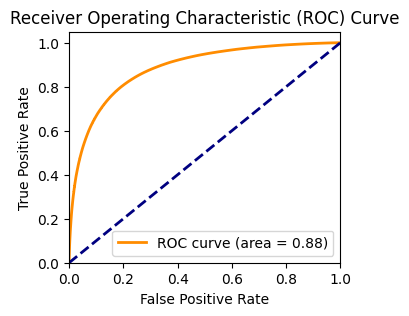

In [16]:
model_mlp.load_state_dict(torch.load('best_model.pth'))

# Final evaluation on the test set
model_mlp.eval()

all_preds = []
all_labels = []
all_probs = []
all_precision = []
all_rand_precision = []
with torch.no_grad():
    for data, labels in test_dataloader:
        outputs = model_mlp(data.float(), )
        probs = outputs.cpu().numpy()
        predicted = (outputs > 0.5).float()
        precision_ = precision_score(labels,predicted)
        
        precision_rand = precision_score(labels,np.random.randint(0,2,len(predicted)))
        
        all_probs.extend(probs)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_precision.extend([precision_])
        all_rand_precision.extend([precision_rand])

# Convert lists to numpy arrays
all_preds = np.array(all_preds).flatten()
all_labels = np.array(all_labels).flatten()
all_probs = np.array(all_probs).flatten()

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(3.5, 3))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
stop

NameError: name 'stop' is not defined

In [ ]:
# # Define the CNN model for time series classification
# class CNN(nn.Module):
#     def __init__(self):
#         super(CNN, self).__init__()
#         self.conv1 = nn.Conv1d(in_channels=256, out_channels=128, kernel_size=3, padding=1)
#         self.bn1 = nn.BatchNorm1d(128)
#         self.relu = nn.ReLU()
#         self.conv2 = nn.Conv1d(in_channels=128, out_channels=64, kernel_size=3, padding=1)
#         self.bn2 = nn.BatchNorm1d(64)
#         self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
#         self.dropout = nn.Dropout(0.5)
#         self.fc1 = nn.Linear(128, 128)  # assuming input length is 10, after pooling it's 5
#         self.bn3 = nn.BatchNorm1d(128)
#         self.fc2 = nn.Linear(128, 1)
#         self.sigmoid = nn.Sigmoid()

#     def forward(self, x):
#         x = self.conv1(x)
#         x = self.bn1(x)
#         x = self.relu(x)
#         x = self.pool(x)
#         x = self.conv2(x)
#         x = self.bn2(x)
#         x = self.relu(x)
#         x = self.pool(x)
#         x = x.view(x.size(0), -1)  # Flatten the tensor
#         x = self.fc1(x)
#         x = self.bn3(x)
#         x = self.relu(x)
#         x = self.dropout(x)
#         x = self.fc2(x)
#         x = self.sigmoid(x)
#         return x

# # Define the training and validation functions
# def train_one_epoch(model, train_loader, criterion, optimizer):
#     model.train()
#     running_loss = 0.0
#     correct_train = 0
#     total_train = 0

#     for data, labels, _ in train_loader:
#         data = data.transpose(1, 2).float()
#         labels = labels.float()
        
#         optimizer.zero_grad()
#         outputs = model(data)
        
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
        
#         running_loss += loss.item()
#         predicted = (outputs > 0.5).float()
#         total_train += labels.size(0)
#         correct_train += (predicted == labels).sum().item()
    
#     train_accuracy = 100 * correct_train / total_train
#     train_loss = running_loss / len(train_loader)
#     return train_loss, train_accuracy

# def validate_one_epoch(model, val_loader, criterion):
#     model.eval()
#     running_val_loss = 0.0
#     correct_val = 0
#     total_val = 0
    
#     with torch.no_grad():
#         for data, labels, _ in val_loader:
#             data = data.transpose(1, 2).float()
#             labels = labels.float()
#             outputs = model(data)
#             loss = criterion(outputs, labels)
#             running_val_loss += loss.item()
#             predicted = (outputs > 0.5).float()
#             total_val += labels.size(0)
#             correct_val += (predicted == labels).sum().item()
    
#     val_loss = running_val_loss / len(val_loader)
#     val_accuracy = 100 * correct_val / total_val
#     return val_loss, val_accuracy

# # Training loop with early stopping
# def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=50, patience=5):
#     best_val_loss = float('inf')
#     early_stopping_counter = 0

#     for epoch in range(num_epochs):
#         train_loss, train_accuracy = train_one_epoch(model, train_loader, criterion, optimizer)
#         val_loss, val_accuracy = validate_one_epoch(model, val_loader, criterion)

#         scheduler.step()
        
#         logging.info(f'Epoch [{epoch+1}/{num_epochs}], '
#                      f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, '
#                      f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

#         # Early stopping
#         if val_loss < best_val_loss:
#             best_val_loss = val_loss
#             early_stopping_counter = 0
#             torch.save(model.state_dict(), 'best_model.pth')
#         else:
#             early_stopping_counter += 1
#             if early_stopping_counter >= patience:
#                 logging.info("Early stopping triggered")
#                 break

# # Initialize logging
# logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# # Example usage
# model_cnn = CNN()

# criterion = nn.BCELoss()
# optimizer = optim.Adam(model_cnn.parameters(), lr=0.001)
# scheduler = CosineAnnealingLR(optimizer, T_max=10)

# train_model(model_cnn, train_loader, val_loader, criterion, optimizer, scheduler)


In [ ]:
def similarity_cosine(vec1, vec2):
    """
    Compute the cosine similarity between two vectors.

    Args:
        vec1 (numpy.ndarray): First vector.
        vec2 (numpy.ndarray): Second vector.

    Returns:
        float: Cosine similarity between vec1 and vec2.
    """
    cosine_similarity_arr = []
    for v1,v2 in zip(vec1, vec2):
        cosine_similarity = np.dot(v1, v2)/(np.linalg.norm(v1)* np.linalg.norm(v2))
        cosine_similarity_arr.append(cosine_similarity)
    return np.array(cosine_similarity_arr)

def load_best_model(model, path='best_model.pth'):
    """
    Load the best model from the given path.

    Args:
        model (torch.nn.Module): The model to load the state dictionary into.
        path (str): Path to the saved model state dictionary.
    """
    model.load_state_dict(torch.load(path))

def evaluate_model(model, dataloader, model_type):
    """
    Evaluate the model on the provided dataloader.

    Args:
        model (torch.nn.Module): The trained model.
        dataloader (torch.utils.data.DataLoader): DataLoader for the dataset.
        encoding_dat (numpy.ndarray): Encoded data.
        c_inx_arr (numpy.ndarray): Concept index array.

    Returns:
        float: Validation accuracy.
        numpy.ndarray: Indices of the samples.
        numpy.ndarray: Model outputs.
        numpy.ndarray: Ground truth labels.
        numpy.ndarray: Correct predictions.
    """
    model.eval()
    correct_val = 0
    total_val = 0

    indices = []
    outputs_list = []
    correct_indices = []
    labels_list = []

    with torch.no_grad():
        for data, labels, inx in dataloader:
            if model_type == "mlp":
                data = data.view(data.size(0), -1).float()  
            elif model_type == "cnn":
                data = data.transpose(1, 2).float()

            labels = labels.float()
            outputs = model(data)
            predicted = (outputs > 0.5).float()
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
            
            # Collect indices, outputs, labels, and correct predictions
            indices.extend(inx.cpu().numpy())
            outputs_list.extend(outputs.cpu().numpy())
            labels_list.extend(labels.cpu().numpy())
            correct_indices.extend((predicted == labels).cpu().numpy())
    
    # Convert lists to numpy arrays
    indices = np.array(indices)
    outputs_list = np.array(outputs_list).flatten()
    labels_list = np.array(labels_list).flatten()
    correct_indices = np.array(correct_indices).flatten()

    val_accuracy = 100 * correct_val / total_val
    return val_accuracy, indices, outputs_list, labels_list, correct_indices

def test_model(model, dataloader, model_type):
    """
    Evaluate the model on the provided dataloader.

    Args:
        model (torch.nn.Module): The trained model.
        dataloader (torch.utils.data.DataLoader): DataLoader for the dataset.
        encoding_dat (numpy.ndarray): Encoded data.
        c_inx_arr (numpy.ndarray): Concept index array.

    Returns:
        float: Validation accuracy.
        numpy.ndarray: Indices of the samples.
        numpy.ndarray: Model outputs.
        numpy.ndarray: Ground truth labels.
        numpy.ndarray: Correct predictions.
    """
    model.eval()

    indices = []
    outputs_list = []  
    predicted_list = []  

    with torch.no_grad():
        for data, inx in dataloader:
            if model_type == "mlp":
                data = data.view(data.size(0), -1).float()  
            elif model_type == "cnn":
                data = data.transpose(1, 2).float()
            
            outputs = model(data)
            predicted = (outputs > 0.5).float()
            
            # Collect indices, outputs, labels, and correct predictions
            indices.extend(inx.cpu().numpy())
            outputs_list.extend(outputs.cpu().numpy())
            predicted_list.extend(predicted.cpu().numpy())
            
    # Convert lists to numpy arrays for sorting
    indices = np.array(indices)
    outputs_list = np.array(outputs_list).flatten()
    predicted_list = np.array(predicted_list).flatten()
    
    return indices, outputs_list, predicted_list

def analyze_novel_predictions(indices, outputs_list, predicted_list, encoding_dat, c_inx_arr):
    """
    Analyze the predictions and print correct predictions for co-occurrence and non-co-occurrence.

    Args:
        indices (numpy.ndarray): Indices of the samples.
        outputs_list (numpy.ndarray): Model outputs.
        labels_list (numpy.ndarray): Ground truth labels.
        correct_indices (numpy.ndarray): Correct predictions.
        encoding_dat (numpy.ndarray): Encoded data.
        c_inx_arr (numpy.ndarray): Concept index array.
    """
    sorted_indices = np.argsort(outputs_list)

    correct_0 = []
    correct_1 = []

    for i in sorted_indices:
        if predicted_list[i]:
            correct_1.append(indices[i])
        else:
            correct_0.append(indices[i])

    print("Correct predictions to have no co-occurrence:")
    print_correct_predictions(correct_0, encoding_dat, c_inx_arr, "no co-occurrence")

    print("\nCorrect predictions to have co-occurrence:")
    print_correct_predictions(correct_1, encoding_dat, c_inx_arr, "co-occurrence")

def analyze_predictions(indices, outputs_list, labels_list, correct_indices, encoding_dat, c_inx_arr):
    """
    Analyze the predictions and print correct predictions for co-occurrence and non-co-occurrence.

    Args:
        indices (numpy.ndarray): Indices of the samples.
        outputs_list (numpy.ndarray): Model outputs.
        labels_list (numpy.ndarray): Ground truth labels.
        correct_indices (numpy.ndarray): Correct predictions.
        encoding_dat (numpy.ndarray): Encoded data.
        c_inx_arr (numpy.ndarray): Concept index array.
    """
    sorted_indices = np.argsort(outputs_list)

    correct_0 = []
    correct_1 = []

    for i in sorted_indices:
        if correct_indices[i]:
            if labels_list[i] == 0:
                correct_0.append(indices[i])
            else:
                correct_1.append(indices[i])

    print("Correct predictions to have no co-occurrence:")
    print_correct_predictions(correct_0, encoding_dat, c_inx_arr, "no co-occurrence")

    print("\nCorrect predictions to have co-occurrence:")
    print_correct_predictions(correct_1, encoding_dat, c_inx_arr, "co-occurrence")

def print_correct_predictions(correct_list, encoding_dat, c_inx_arr, label):
    """
    Print the correct predictions with their slopes.

    Args:
        correct_list (list): List of correct predictions.
        encoding_dat (numpy.ndarray): Encoded data.
        c_inx_arr (numpy.ndarray): Concept index array.
        label (str): Label for the type of correct prediction (co-occurrence or no co-occurrence).
    """
    x = np.arange(31).reshape(-1, 1)
    lin_model = LinearRegression()

    for cnt, idx in enumerate(correct_list):
        sim = similarity_cosine(encoding_dat[idx[0]][0], encoding_dat[idx[1]][0])
        lin_model.fit(x, sim.reshape(-1, 1))
        slope = lin_model.coef_[0][0]
        print(c_inx_arr[idx[0]], c_inx_arr[idx[1]], np.round(slope, 3))
        if cnt == 5:
            break

In [ ]:
# Initialize logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Load the best model
load_best_model(model_mlp)

# Final evaluation on the validation set
val_accuracy, indices, outputs_list, labels_list, correct_indices = evaluate_model(model_mlp, testing_dataloader, c_encoding_arr, c_inx_arr)

# Analyze predictions
analyze_predictions(indices, outputs_list, labels_list, correct_indices, c_encoding_arr, c_inx_arr)

# Print final validation accuracy
logging.info(f"\nValidation Accuracy: {val_accuracy:.2f}%")

2024-06-21 17:41:41,307 - INFO - 
Validation Accuracy: 76.93%


Correct predictions to have no co-occurrence:
['beat_frequency'] ['hidden_subgroup'] -0.013
['chromatic_number'] ['pulse_energy'] 0.005
['tunneling_strength'] ['abelian_group'] -0.008
['quantum_finite_automaton'] ['magnetic_sensing'] -0.009
['kraus_map'] ['emitted_spectrum'] 0.002
['spatial_multiplexing'] ['solvable_group'] 0.003

Correct predictions to have co-occurrence:
['scale_length'] ['macroscopic_quantum_state'] 0.004
['lee_yang'] ['ultrarelativistic_limit'] 0.004
['central_force'] ['conserved_quantity'] 0.012
['square_integrable_function'] ['nonlocal_operator'] 0.002
['absorption_cell'] ['synchrotron_radiation'] -0.004
['power_series'] ['internal_memory'] 0.002


In [ ]:
# Initialize logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Load the best model
load_best_model(model_mlp)

# Final evaluation on the validation set
indices, outputs_list, predicted_list = test_model(model_mlp, novel_dataloader)

# Analyze predictions
analyze_novel_predictions(indices, outputs_list, predicted_list, c_encoding_arr, c_inx_arr)

# Print final validation accuracy
logging.info(f"\nValidation Accuracy: {val_accuracy:.2f}%")

2024-06-21 17:42:29,759 - INFO - 
Validation Accuracy: 76.93%


Correct predictions to have no co-occurrence:
['noise_spectrum'] ['hidden_subgroup_problem'] -0.014
['visible_spectrum'] ['hidden_subgroup_problem'] -0.012
['single_photon_blockade'] ['solvable_group'] 0.0
['spectrum_analyzer'] ['hidden_subgroup_problem'] 0.006
['energy_transport'] ['hidden_shift'] 0.003
['atom_localization'] ['hidden_subgroup'] 0.0

Correct predictions to have co-occurrence:
['qubit_network'] ['high_dimensional_quantum_information'] 0.001
['wigner_transformation'] ['adiabatic_computation'] -0.013
['field_propagator'] ['electron_double_quantum_dot'] 0.006
['photonic_quantum_technology'] ['structure_learning'] 0.01
['coin_flipping'] ['optical_spectrum'] -0.002
['matrix_exponential'] ['annealing_protocol'] -0.01


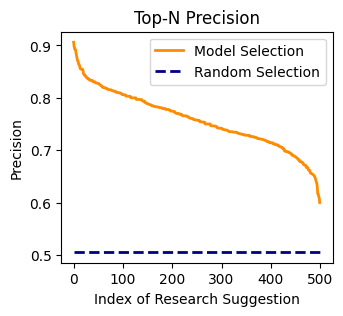

In [ ]:
# take a random pair 


plt.figure(figsize=(3.5, 3))
plt.plot(np.sort(all_precision)[:500][::-1], color='darkorange', lw=2, label="Model Selection")
plt.plot([0, 500], [np.mean(all_rand_precision), np.mean(all_rand_precision)], color='navy', lw=2, linestyle='--',label="Random Selection")
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
plt.xlabel('Index of Research Suggestion')
plt.ylabel('Precision')
plt.title('Top-N Precision')
plt.legend(loc="upper right")
plt.show()



top words over time 

In [ ]:
year_arr = np.load("files/year_arr.npy", mmap_mode="r")
from gensim.models import Word2Vec

concept_arr = np.unique(np.load("files/overlapping_concepts.npy"))
for year in np.unique(year_arr):
        
    loaded_w2v = Word2Vec.load("saved_models/model_year_{}.model".format(year))

    try:
        vec_enc = loaded_w2v.wv.get_vector("machine_learning")
        sim = np.array(loaded_w2v.wv.most_similar("machine_learning"))
        print(year)
        for s in sim[:,0]:
            if s in concept_arr:
                print(s)
        print("\n")
    except:
        pass
    
    
    

In [ ]:
year_arr = np.load("files/year_arr.npy", mmap_mode="r")
from gensim.models import Word2Vec

concept_arr = np.unique(np.load("files/overlapping_concepts.npy"))
for year in np.unique(year_arr):
        
    loaded_w2v = Word2Vec.load("saved_models/model_year_{}.model".format(year))

    try:
        vec_enc = loaded_w2v.wv.get_vector("phase_transition")
        sim = np.array(loaded_w2v.wv.most_similar("machine_learning"))
        print(year)
        for s in sim[:,0]:
            if s in concept_arr:
                print(s)
        print("\n")
    except:
        pass
    
    
    

1997
personal_identification
secure_computation
private_information
quantum_bit_commitment
oblivious_transfer
class_function
quantum_mechanical_consideration


1998
personal_identification
secure_computation
private_information
quantum_bit_commitment
oblivious_transfer
class_function
quantum_mechanical_consideration
algebraic_expression


1999
personal_identification
secure_computation
private_information
quantum_bit_commitment
oblivious_transfer
quantum_mechanical_consideration
algebraic_expression
channel_code
cell_structure


2000
personal_identification
secure_computation
private_information
quantum_bit_commitment
quantum_mechanical_consideration
algebraic_expression
channel_code
cell_structure
boolean_value


2001
personal_identification
secure_computation
private_information
quantum_bit_commitment
quantum_mechanical_consideration
algebraic_expression
channel_code
cell_structure
boolean_value
information_theoretic_bound


2002
personal_identification
secure_computation
private_inf

In [ ]:
# # Load the best model
# model.load_state_dict(torch.load('best_model.pth'))

# # Final evaluation on the validation set
# model.eval()
# correct_val = 0
# total_val = 0

# indices = []
# outputs_list = []
# correct_indices = []
# labels_list = []

# x = np.arange(31).reshape(-1, 1)
# lin_model = LinearRegression()

# with torch.no_grad():
#     for data, labels, inx in testing_dataloader:
#         data = data.view(data.size(0), -1).float()  # Flatten the input data
#         labels = labels.float()
#         outputs = model(data)
#         predicted = (outputs > 0.5).float()
#         total_val += labels.size(0)
#         correct_val += (predicted == labels).sum().item()
        
#         # Collect indices, outputs, labels, and correct predictions
#         indices.extend(inx.cpu().numpy())
#         outputs_list.extend(outputs.cpu().numpy())
#         labels_list.extend(labels.cpu().numpy())
#         correct_indices.extend((predicted == labels).cpu().numpy())
        

# # Convert lists to numpy arrays for sorting
# indices = np.array(indices)
# outputs_list = np.array(outputs_list).flatten()
# labels_list = np.array(labels_list).flatten()
# correct_indices = np.array(correct_indices).flatten()

# # Get sorted indices of the outputs
# sorted_indices = np.argsort(outputs_list)

# # Separate the indices of correct predictions into two categories
# correct_0 = []
# correct_1 = []

# for i in sorted_indices:
#     if correct_indices[i]:
#         if labels_list[i] == 0:
#             correct_0.append(indices[i])
#         else:
#             correct_1.append(indices[i])

# # Print indices of correct predictions
# print("Correct predictions to have no co-occurance:")
# for cnt,idx in enumerate(correct_0):
#     sim = similarity_cosine(encoding_dat[idx[0]][0],encoding_dat[idx[1]][0])
#     lin_model.fit(x, sim.reshape(-1, 1))
#     slope = lin_model.coef_[0][0]
#     print(c_inx_arr[idx[0]],c_inx_arr[idx[1]], np.round(slope,3))
#     if cnt ==5:
#         break

# print("\n Correct predictions to have co-occurance:")
# for cnt,idx in enumerate(correct_1):
#     sim = similarity_cosine(encoding_dat[idx[0]][0],encoding_dat[idx[1]][0])
#     lin_model.fit(x, sim.reshape(-1, 1))
#     slope = lin_model.coef_[0][0]
#     print(c_inx_arr[idx[0]],c_inx_arr[idx[1]], np.round(slope,3))
#     if cnt ==5:
#         break

# print(f"\nValidation Accuracy: {100 * correct_val / total_val:.2f}%")

In [ ]:
# # Load the best model
# model.load_state_dict(torch.load('best_model.pth'))

# # Final evaluation on the validation set
# model.eval()
# correct_val = 0
# total_val = 0

# indices = []
# outputs_list = []
# predicted_list = []

# with torch.no_grad():
#     for data, inx in novel_dataloader:
#         data = data.view(data.size(0), -1).float()  # Flatten the input data
        
#         outputs = model(data)
#         predicted = (outputs > 0.5).float()
        
#         # Collect indices, outputs, labels, and correct predictions
#         indices.extend(inx.cpu().numpy())
#         outputs_list.extend(outputs.cpu().numpy())
#         predicted_list.extend(predicted.cpu().numpy())
        
# # Convert lists to numpy arrays for sorting
# indices = np.array(indices)
# outputs_list = np.array(outputs_list).flatten()
# predicted_list = np.array(predicted_list).flatten()


# # Get sorted indices of the outputs
# sorted_indices = np.argsort(outputs_list)

# # Separate the indices of correct predictions into two categories
# correct_0 = []
# correct_1 = []

# for i in sorted_indices:
#     if predicted_list[i]:
#         correct_1.append(indices[i])
#     else:
#         correct_0.append(indices[i])

# # Print indices of correct predictions
# print(" Predictions to have no co-occurance:")
# for cnt,idx in enumerate(correct_0):
#     sim = similarity_cosine(encoding_dat[idx[0]][0],encoding_dat[idx[1]][0])
#     lin_model.fit(x, sim.reshape(-1, 1))
#     slope = lin_model.coef_[0][0]
#     print(c_inx_arr[idx[0]],c_inx_arr[idx[1]], np.round(slope,3))
#     if cnt ==5:
#         break

# print("\n Predictions to have co-occurance:")
# for cnt,idx in enumerate(correct_1):
#     sim = similarity_cosine(encoding_dat[idx[0]][0],encoding_dat[idx[1]][0])
#     lin_model.fit(x, sim.reshape(-1, 1))
#     slope = lin_model.coef_[0][0]
#     print(c_inx_arr[idx[0]],c_inx_arr[idx[1]],np.round(slope,3))
#     if cnt ==5:
#         break

### Simple baseline: Dot Product and cosine sim at time t


In [ ]:
class BaselineDataset(Dataset):
    def __init__(self, data: np.ndarray, word_co_occurrences: dict, year_arr: np.ndarray, c_inx_arr: np.ndarray, 
                 input_window_size: int = 5, output_window_size: int = 3, offset_to_current_year: int = 1):
        """
        Dataset for time series data.

        Args:
            data (np.ndarray): The input data.
            word_co_occurrences (dict): Dictionary of word co-occurrences.
            year_arr (np.ndarray): Array of years.
            c_inx_arr (np.ndarray): Array of concept indices.
            input_window_size (int, optional): Size of the input window. Defaults to 5.
            output_window_size (int, optional): Size of the output window. Defaults to 3.
            offset_to_current_year (int, optional): Offset to the current year. Defaults to 1.
        """
        self.train_window_data = data[:, -input_window_size-output_window_size-offset_to_current_year:-output_window_size-offset_to_current_year]
        self.label_year_range = (year_arr[-output_window_size:] if offset_to_current_year == 0 
                                 else year_arr[-output_window_size-offset_to_current_year:-offset_to_current_year])

        self.co_occur_concept_pair_arr = self.get_co_occur_concept_pair_after_year_arr(
            word_co_occurrences, self.label_year_range[0], self.label_year_range[-1])
        self.c_inx_arr = c_inx_arr
        self.input_window_size = input_window_size
        self.output_window_size = output_window_size
        self.offset_to_current_year = offset_to_current_year

    def __len__(self) -> int:
        return 64 * 5000

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        return (self._get_positive_sample() if np.random.rand() < 0.5 else self._get_negative_sample())

    def _get_positive_sample(self) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        while True:
            sampled_pairs = np.random.choice(len(self.co_occur_concept_pair_arr), size=1)
            c_pair = self.co_occur_concept_pair_arr[sampled_pairs][0]
            inx_0 = np.where(self.c_inx_arr == c_pair[0])[0]
            inx_1 = np.where(self.c_inx_arr == c_pair[1])[0]
            if inx_0.size > 0 and inx_1.size > 0:
                break
        enc_0 = self.train_window_data[inx_0][0][-1,:]
        enc_1 = self.train_window_data[inx_1][0][-1,:]
        
        return torch.from_numpy(enc_0), torch.from_numpy(enc_1),  torch.ones(1), torch.from_numpy(np.array([inx_0, inx_1]))

    def _get_negative_sample(self) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        while True:
            sampled_pair = np.random.choice(self.train_window_data.shape[0], size=2)
            if self.c_inx_arr[sampled_pair[1]] not in word_co_occurrences[self.c_inx_arr[sampled_pair[0]]]:
                break
        inx_0 = np.where(self.c_inx_arr == self.c_inx_arr[sampled_pair[0]])[0]
        inx_1 = np.where(self.c_inx_arr == self.c_inx_arr[sampled_pair[1]])[0]
        enc_0 = self.train_window_data[inx_0][0][-1,:]
        enc_1 = self.train_window_data[inx_1][0][-1,:]
        
        return torch.from_numpy(enc_0), torch.from_numpy(enc_1), torch.zeros(1), torch.from_numpy(np.array([inx_0, inx_1]))

    def _check_indexing(self):
        print(f"Training Window: {self._get_years_range(-self.input_window_size-self.output_window_size-self.offset_to_current_year, -self.output_window_size-self.offset_to_current_year)}")
        print(f"Label Window: {self._get_years_range(-self.output_window_size-self.offset_to_current_year, -self.offset_to_current_year)}")

    def _get_years_range(self, start: int, end: int) -> np.ndarray:
        # return np.unique(saved_year_arr)[start:end]
    
        return (np.unique(saved_year_arr)[start:] if end == -0 
                                 else np.unique(saved_year_arr)[start:end])

    @staticmethod
    def get_co_occur_concept_pair_after_year_arr(word_co_occurrences: dict, first_occ_year: int, final_occ_year: int) -> np.ndarray:
        
        co_occur_concept_pair_arr = []
        for concept, v in word_co_occurrences.items():
            for co_concept, years in v.items():
                if np.min(years) >= first_occ_year and np.max(years)<=final_occ_year:
                    co_occur_concept_pair_arr.append([concept,co_concept])
        return np.array(co_occur_concept_pair_arr)

        



# Example usage:
num_samples_per_class = 32
num_features = 128
seq_length = 10
out_length = 3
batch_size = 128

print("Representation Vectors for tracked concepts",c_encoding_arr.shape)
print("Concept associted with representation", c_inx_arr.shape)
scaler = RobustScaler()
reshaped_data = c_encoding_arr.reshape(-1, c_encoding_arr.shape[-1])  # Shape: (10000*31, 128)
normalized_data = scaler.fit_transform(reshaped_data)
encoding_data = normalized_data.reshape(c_encoding_arr.shape)

dataset_baseline = BaselineDataset(data=encoding_data, word_co_occurrences=word_co_occurrences, year_arr=np.unique(saved_year_arr), 
                            c_inx_arr=c_inx_arr, input_window_size = seq_length, output_window_size = out_length, offset_to_current_year = 3)

train_size = int(0.8 * len(dataset))
val_size = len(dataset_baseline) - train_size
train_baseline_dataset, val_baseline_dataset = random_split(dataset, [train_size, val_size])

train_baseline_loader = DataLoader(train_baseline_dataset, batch_size=batch_size, shuffle=True)
val_baseline_loader = DataLoader(val_baseline_dataset, batch_size=batch_size, shuffle=True)

testing_baseline_dataset = BaselineDataset(data=encoding_data, word_co_occurrences=word_co_occurrences, year_arr=np.unique(saved_year_arr), 
                            c_inx_arr=c_inx_arr, input_window_size = seq_length, output_window_size = out_length, offset_to_current_year = 0)
testing_baseline_dataset._check_indexing()
testing_baseline_dataloader = DataLoader(testing_baseline_dataset, batch_size=batch_size, shuffle=True)

Representation Vectors for tracked concepts (19161, 31, 128)
Concept associted with representation (19161,)
Training Window: [2009 2010 2011 2012 2013 2014 2015 2016 2017 2018]
Label Window: [2019 2020 2021]

Training Window: [2012 2013 2014 2015 2016 2017 2018 2019 2020 2021]
Label Window: [2022 2023 2024]


Confusion Matrix:
[[31740 32114]
 [18973 45301]]


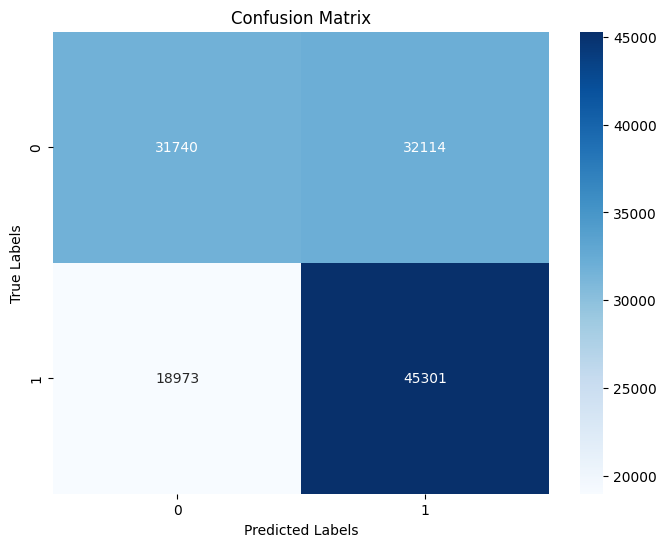

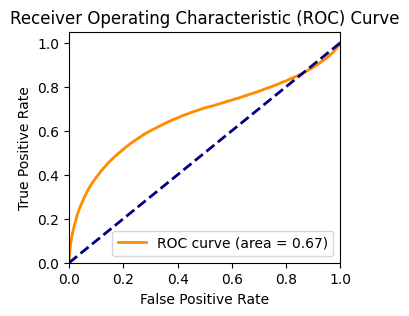

In [ ]:
class CosineSimilarityModel(nn.Module):
    def __init__(self):
        super(CosineSimilarityModel, self).__init__()

    def forward(self, vec1, vec2):
        # Ensure the input vectors are of the same shape
        assert vec1.shape == vec2.shape, "Input vectors must have the same shape"
        
        # Compute cosine similarity
        # cosine_similarity = F.cosine_similarity(vec1, vec2, dim=-1)
        elementwise_product = vec1 * vec2

        # Sum along the feature dimension (dim=1)
        cosine_similarity = elementwise_product.sum(dim=1)
        
        return cosine_similarity

class CosineSimilarityClassifier(nn.Module):
    def __init__(self):
        super(CosineSimilarityClassifier, self).__init__()
        self.cos_sim_model = CosineSimilarityModel()

    def forward(self, vec1, vec2):
        # Compute cosine similarity
        cosine_similarity = self.cos_sim_model(vec1, vec2)
        
        # Rescale cosine similarity from [-1, 1] to [0, 1]
        rescaled_similarity = (cosine_similarity + 1) / 2
        
        # Binary classification (class 1 if similarity >= 0.5, else class 0)
        
        
        return rescaled_similarity


model_cos = CosineSimilarityClassifier()

all_preds = []
all_labels = []
all_probs = []
all_precision = []
all_rand_precision = []


for cnt, (enc_0, enc_1, labels, _) in enumerate(testing_baseline_dataloader):
    enc_0 = enc_0.float()
    enc_1 = enc_1.float()
    
    labels = labels.float()
    
    
    outputs = model_cos(enc_0, enc_1).view(-1,1)

    
    
    probs = outputs.cpu().numpy()
    predicted = (outputs > 0.5).float()
    precision_ = precision_score(labels,predicted)
    
    precision_rand = precision_score(labels,np.random.randint(0,2,len(predicted)))
    
    all_probs.extend(probs)
    all_preds.extend(predicted.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())
    all_precision.extend([precision_])
    all_rand_precision.extend([precision_rand])
    
    if cnt == 1000:
        break

# Convert lists to numpy arrays
all_preds = np.array(all_preds).flatten()
all_labels = np.array(all_labels).flatten()
all_probs = np.array(all_probs).flatten()

# Calculate confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(3.5, 3))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()